# Task 1: Term Deposit Subscription Prediction (Bank Marketing)

**Objective:** Predict whether a bank customer will subscribe to a term deposit after a marketing campaign.

**Models:** Logistic Regression, Random Forest  
**Metrics:** Confusion Matrix, F1-score, ROC-AUC + ROC Curve  
**Explainability:** SHAP explanations for at least 5 individual predictions


In [16]:
!pip install shap


In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, roc_auc_score, roc_curve, classification_report
)

import shap


In [18]:
# Update this path to your downloaded UCI Bank Marketing dataset file
# Common filename: bank-full.csv (semicolon-separated)
DATA_PATH = "bank-full.csv"

df = pd.read_csv(DATA_PATH, sep=";")
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [19]:
print("Shape:", df.shape)
display(df.info())
display(df.describe(include="all").T.head(20))

target_col = "y"
print("\nTarget distribution:")
display(df[target_col].value_counts(normalize=True))


Shape: (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45211.0,NaN,NaN,NaN,40.93621,10.618762,18.0,33.0,39.0,48.0,95.0
job,45211,12,blue-collar,9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,45211,3,married,27214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,45211,4,secondary,23202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,45211,2,no,44396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,45211.0,NaN,NaN,NaN,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211,2,yes,25130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,45211,2,no,37967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,45211,3,cellular,29285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,45211.0,NaN,NaN,NaN,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0



Target distribution:


y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [20]:
X = df.drop(columns=[target_col])
y = (df[target_col] == "yes").astype(int)  # 1=yes, 0=no

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((36168, 16), (9043, 16))

In [21]:
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


=== Logistic Regression ===
F1: 0.5527
ROC-AUC: 0.9079

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.81      0.55      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.83      0.73      9043
weighted avg       0.91      0.85      0.87      9043



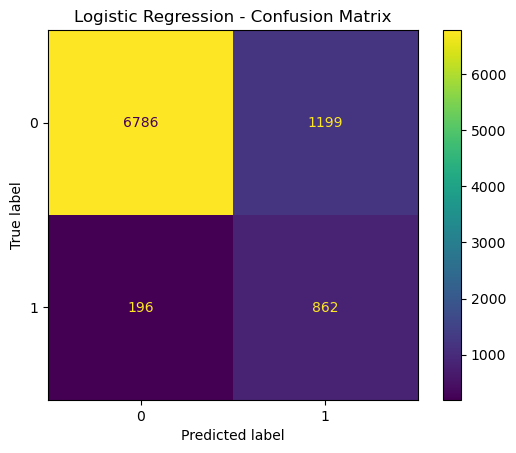

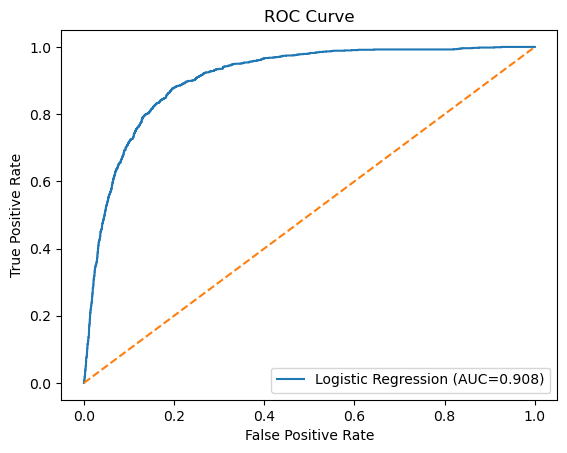

=== Random Forest ===
F1: 0.4619
ROC-AUC: 0.9301

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.69      0.35      0.46      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.66      0.71      9043
weighted avg       0.89      0.91      0.89      9043



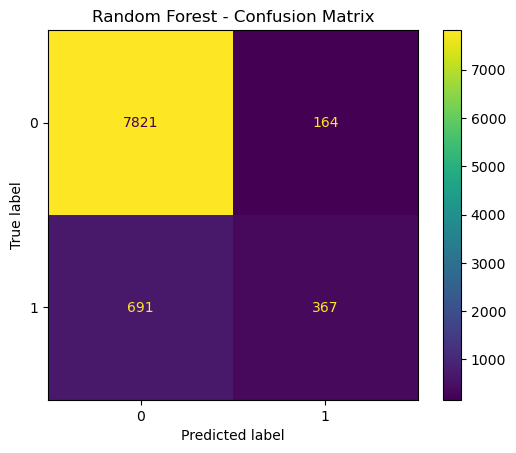

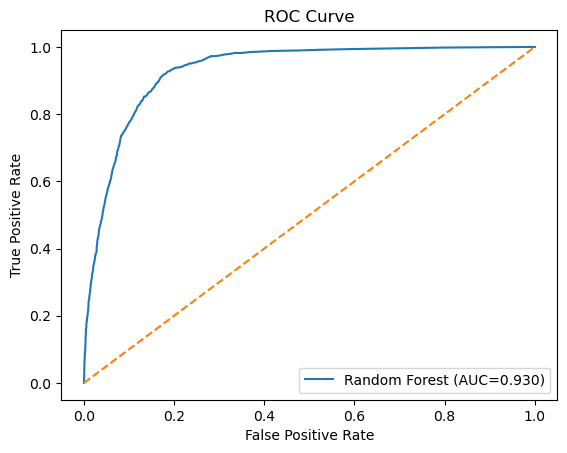

({'f1': 0.5527412632253927, 'auc': 0.9079218714674134},
 {'f1': 0.4619257394587791, 'auc': 0.9300584271312113})

In [22]:
def evaluate(model, X_te, y_te, title="Model"):
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    f1 = f1_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba)

    print(f"=== {title} ===")
    print("F1:", round(f1, 4))
    print("ROC-AUC:", round(auc, 4))
    print("\nClassification report:\n", classification_report(y_te, y_pred))

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_te, y_proba)
    plt.plot(fpr, tpr, label=f"{title} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return {"f1": f1, "auc": auc}

scores_lr = evaluate(logreg, X_test, y_test, "Logistic Regression")
scores_rf = evaluate(rf, X_test, y_test, "Random Forest")
scores_lr, scores_rf


In [23]:
best_model = rf if scores_rf["f1"] >= scores_lr["f1"] else logreg
best_name = "Random Forest" if best_model is rf else "Logistic Regression"
print("Best model:", best_name)

Best model: Logistic Regression


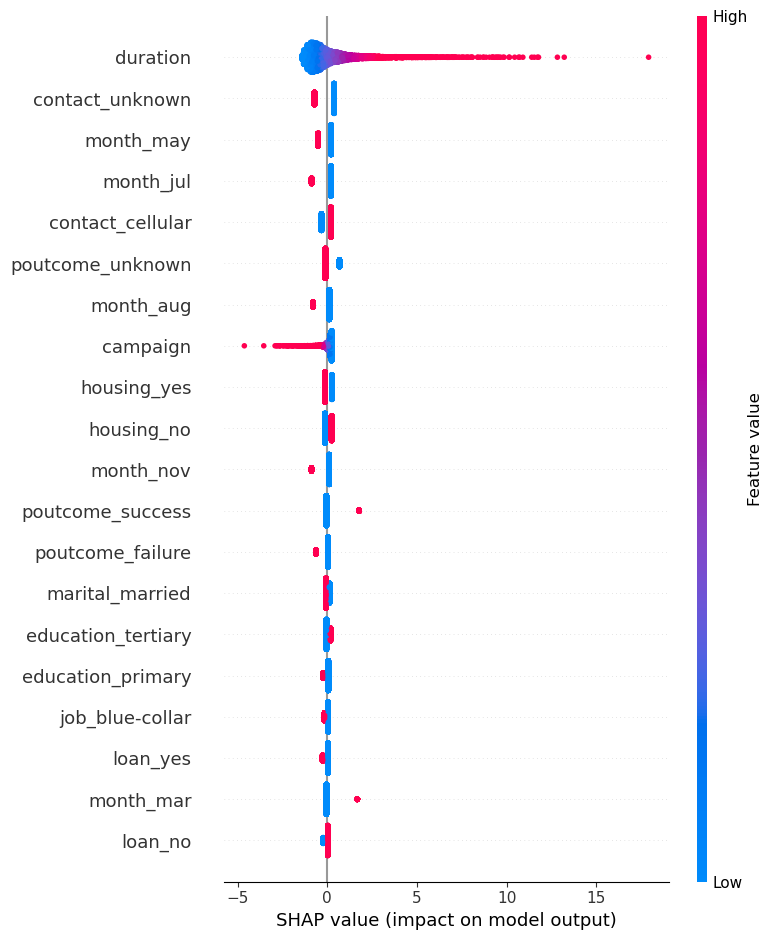

In [24]:
# Transform data using the fitted preprocessing
prep = best_model.named_steps["prep"]
model = best_model.named_steps["model"]

X_train_enc = prep.transform(X_train)
X_test_enc = prep.transform(X_test)

# Get feature names after OneHotEncoding
ohe = prep.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, cat_feature_names]

# SHAP explainer selection
# TreeExplainer for RandomForest; LinearExplainer for LogisticRegression
if best_name == "Random Forest":
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_enc)
    # For binary classification with TreeExplainer, class 1 is often index 1
    shap_vals_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values
else:
    # background can be a sample of training data
    background = shap.sample(X_train_enc, 200, random_state=42)
    explainer = shap.LinearExplainer(model, background)
    shap_vals_class1 = explainer.shap_values(X_test_enc)

# Global summary
shap.summary_plot(shap_vals_class1, features=X_test_enc, feature_names=feature_names)


Chosen indices: [np.int64(666), np.int64(3689), np.int64(6166), np.int64(1516), 6850]

--- Prediction 666 ---
Predicted prob: 0.9999999972329918  Pred class: 1  True: 0


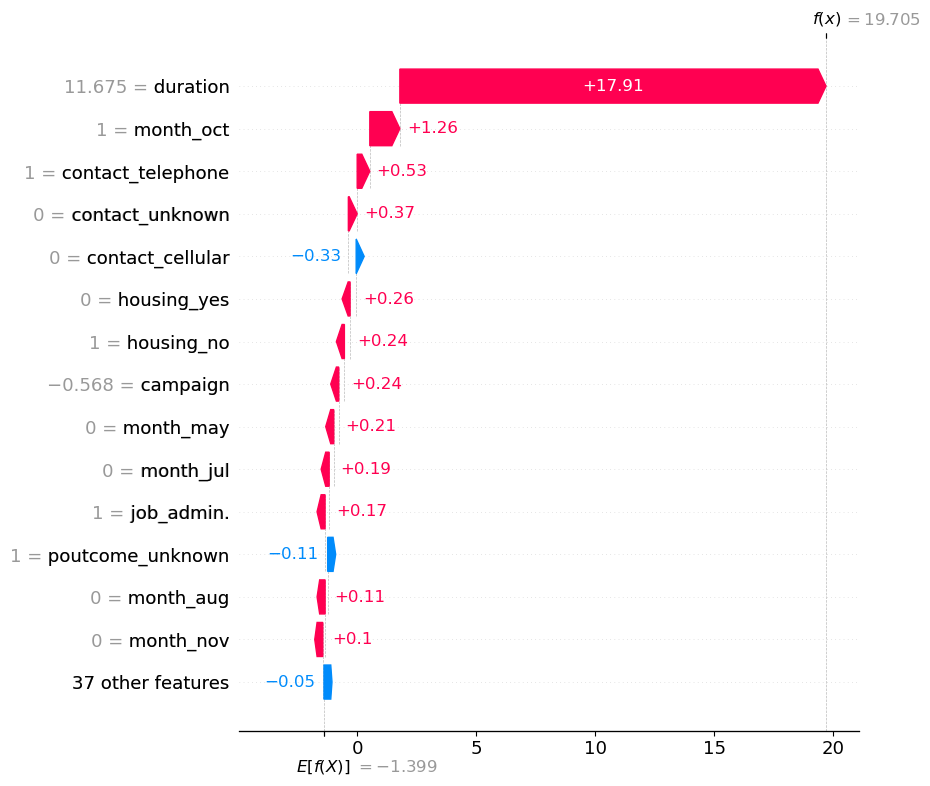


--- Prediction 3689 ---
Predicted prob: 0.9999996292518496  Pred class: 1  True: 1


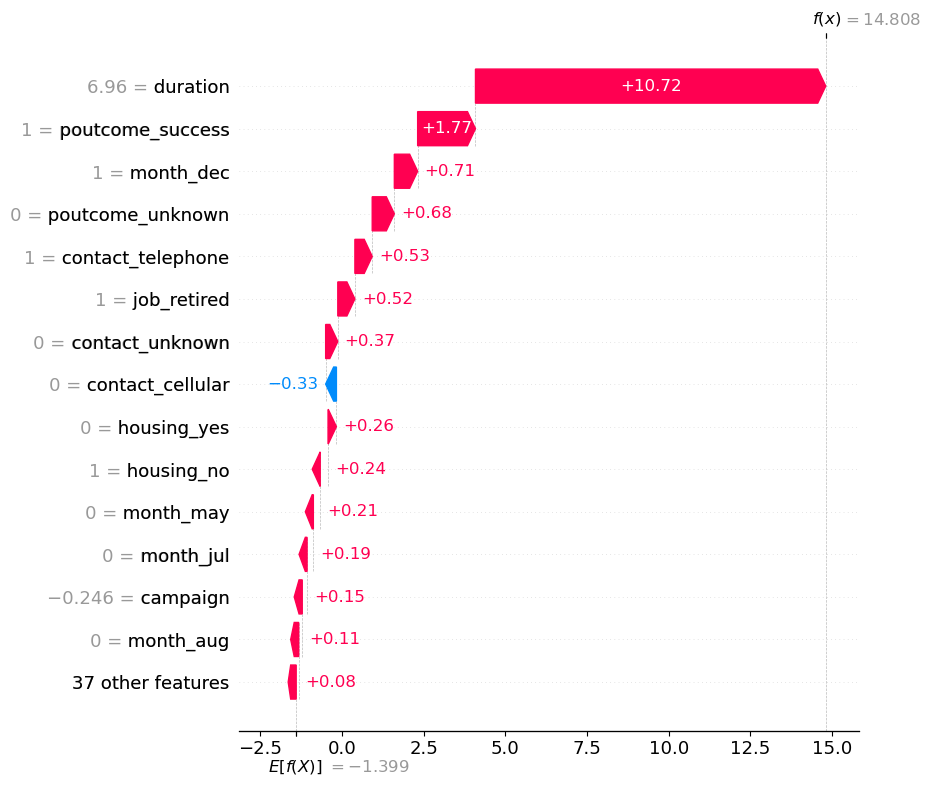


--- Prediction 6166 ---
Predicted prob: 0.00031670140527859396  Pred class: 0  True: 0


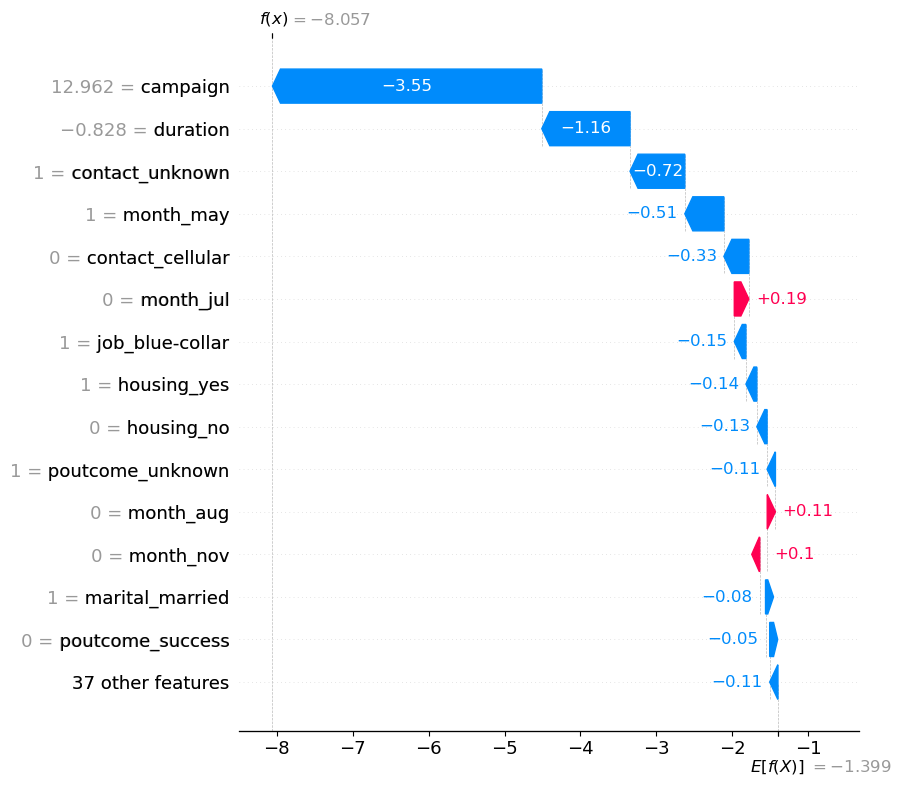


--- Prediction 1516 ---
Predicted prob: 0.0008398479287652157  Pred class: 0  True: 0


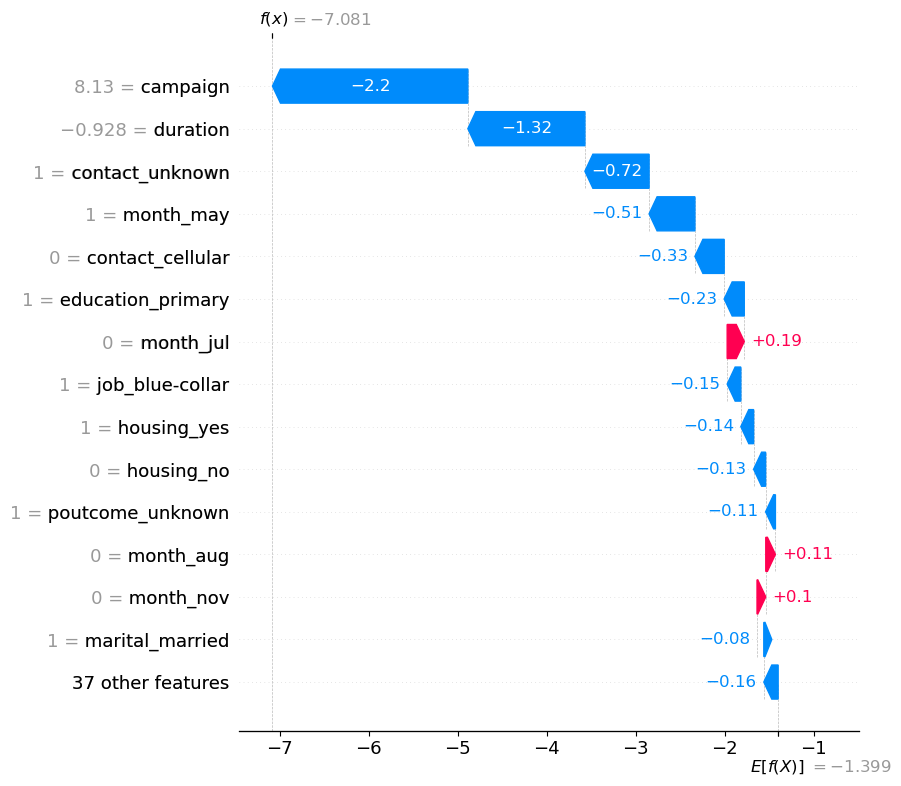


--- Prediction 6850 ---
Predicted prob: 0.4999414643116099  Pred class: 0  True: 0


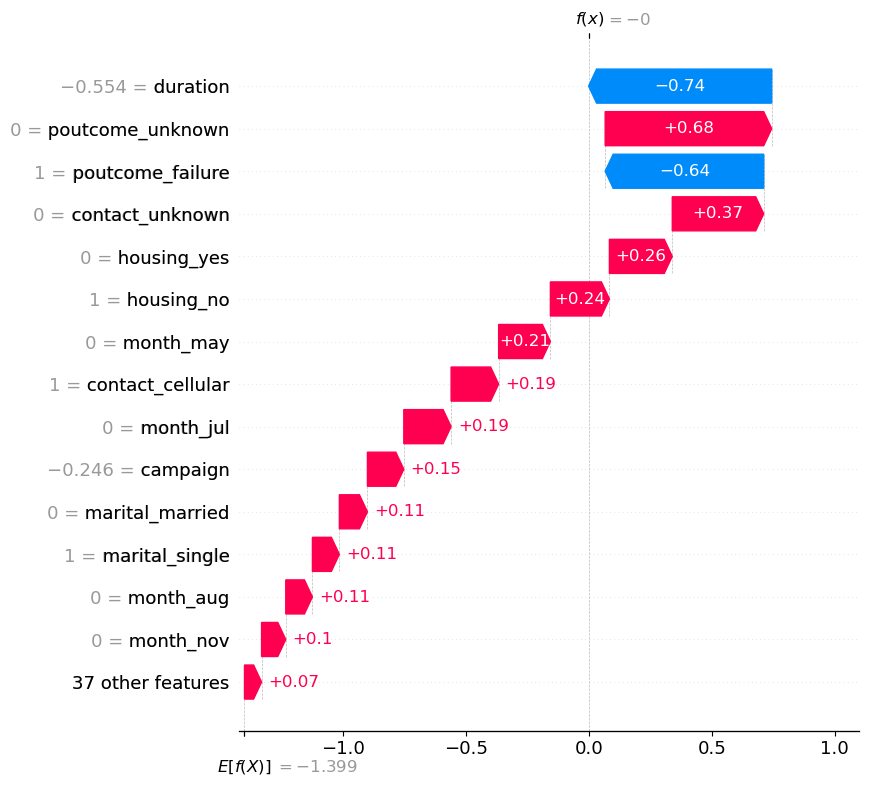

In [25]:
# Pick 5 interesting test samples: mix of positives/negatives
test_df = X_test.copy()
proba = best_model.predict_proba(X_test)[:, 1]
pred = best_model.predict(X_test)

pick_idx = []
# top confident positives
pick_idx += list(np.argsort(-proba)[:2])
# top confident negatives
pick_idx += list(np.argsort(proba)[:2])
# one borderline case
pick_idx += [int(np.argsort(np.abs(proba - 0.5))[0])]

pick_idx = list(dict.fromkeys(pick_idx))[:5]  # unique, max 5
print("Chosen indices:", pick_idx)

for i in pick_idx:
    print("\n--- Prediction", i, "---")
    print("Predicted prob:", float(proba[i]), " Pred class:", int(pred[i]), " True:", int(y_test.iloc[i]))

    # Waterfall plot
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals_class1[i],
            base_values=explainer.expected_value[1] if best_name=="Random Forest" and isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
            data=X_test_enc[i].toarray().ravel() if hasattr(X_test_enc[i], "toarray") else X_test_enc[i],
            feature_names=feature_names
        ),
        max_display=15
    )
    plt.show()


## Conclusion
- Report best model and metrics (F1, ROC-AUC).
- Summarize key drivers from SHAP (top global features).
- Give 2–3 business insights: who is more likely to subscribe and how the bank can target them.
